# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import glob

Frame the Problem and Look at the Big Picture
=============================================

1. **Define the objective in business terms:** Developing a machine learning model to predict delays and cancellations and their types 7 days in advance. Customers satisfaction would increase if delays and cancellations could be predicted earlier. This would also cut costs and better prepare airports.
2. **How will your solution be used?** Will be used to predict delays and cancellations to better prepare customers and airports and save money. 
3. **What are the current solutions/workarounds (if any)?** Manually look at weather, historical data, and quick decision making. Delays are known when they occur and not as far in advance to be useful.
4. **How should you frame this problem?** It is a Supervised Multiclassification problem for delays and cancellations and the delays length and the causes of delays and cancellations.
5. **How should performance be measured? Is the performance measure aligned with the business objective?** Accuracy, precision, ROC-AUC, f1 score and recall with focus on recall.
6. **What would be the minimum performance needed to reach the business objective?** Asked for 25% increase would be great.
7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** MNIST and Iris data sets would be useful for experience for classification and multiclass.
8. **Is human expertise available?** Flights can be somewhat predictably predicted but not too great.
9. **How would you solve the problem manually?** Look at trends and weather data. Check for holidays, and how full an airport is. Check if an inbound plane is late as this leads to the next flight being delayed most likely.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** Weather causes delays the most. Some flight paths are more likely to be delayed than others. Some carriers are more likely to be delayed or cancelled as well as some airports are more likely too.

**Posibile Target Labels**
* ARR_DELAY (Arrival Delay): This could be the main label we're trying to predict, as it directly relates to flight performance (whether the flight is on time or delayed).

* CANCELLED (Flight Cancellation): This could also be a target label since we're trying to predict whether a flight will be cancelled or not (binary classification: 0 = not cancelled, 1 = cancelled).

**Posible Feature Extractions** 
Time-based Features:

* Day of the Week: Extract the day of the week from the FL_DATE (Flight Date) to capture patterns like weekend flights being more prone to delays.
* Month and Quarter: Create features based on MONTH and QUARTER to detect seasonal effects, such as more delays during certain months or quarters (e.g., holiday seasons or weather-related issues).
* Time of Day (e.g., Morning, Afternoon, Evening): Can create a categorical feature from CRS_DEP_TIME (Scheduled Departure Time) to analyze whether flights during certain times of day experience more delays.

Categorical Encoding:

* Carrier and Airport Features: Features such as MKT_UNIQUE_CARRIER, OP_CARRIER, ORIGIN, and DEST can be encoded into numerical format using one-hot encoding or label encoding. This can help capture patterns related to specific airlines, routes, or airports that have frequent delays or cancellations.
* Airline's Flight Number: Features like MKT_CARRIER_FL_NUM could be important as they could help identify patterns for specific flight routes (e.g., certain flight numbers having higher delays).

Aggregated Delay Features:

* Total Delays: Create a feature that sums up different delay types like CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY to get a total "cause of delay" metric.
Flight Delay History: Extract patterns from past delays, such as calculating the average delay for a specific flight or airline over the past month or year.

Duration Features:

* Flight Duration: Can use ACTUAL_ELAPSED_TIME and CRS_ELAPSED_TIME to compute the actual duration of the flight and the difference between the actual and scheduled times (e.g., a new feature like DELTA_ELAPSED_TIME).
* Taxi Time Features: TAXI_OUT, WHEELS_OFF, TAXI_IN, WHEELS_ON could be used to capture taxiing times before and after the flight, which can sometimes be an indicator of delays.

Distance-related Features:

* Flight Distance: Could create derived features like the ratio of DISTANCE to ACTUAL_ELAPSED_TIME to understand the speed or efficiency of the flight.

Categorical Interaction Features:

* Carrier-Airport Interaction: Interaction between MKT_CARRIER and ORIGIN or DEST can be useful in understanding how specific carriers perform at certain airports.
* Departure-Arrival Airport Pairing: Create a new feature from combinations of ORIGIN and DEST to understand route-specific behavior.

**Unusable or Irrelevant Features:** 

Features with 100% Missing Data:

* Features such as DIV4_AIRPORT, DIV5_AIRPORT, DIV4_WHEELS_ON, DIV5_WHEELS_ON, etc., are almost entirely missing data (100%). These should be dropped as they won't provide any value for analysis.

Unique Identifiers or Non-Informative Features:

* TAIL_NUM (Tail Number): This is a unique identifier for each aircraft and does not contribute to the prediction of delays or cancellations.
DUP: This feature seems to be a flag or a duplicate flag but is not clear from the data provided. It likely doesn't contribute to the problem.
DIV_AIRPORT_*, DIV_TAIL_NUM, etc., are likely to represent auxiliary features related to diverted flights, but they are mostly missing or redundant in 
their current state.

Features with Nearly All Data Missing:

* Features like SCH_OP_UNIQUE_CARRIER, SCH_OP_CARRIER_AIRLINE_ID, and SCH_OP_CARRIER_FL_NUM have over 99% missing data. These features are not useful in their current state and can likely be dropped.

Unclear Features:

* CANCELLATION_CODE is mostly missing (98.67%), and may not be useful unless a significant portion of data is filled or transformed into something else (like a binary cancellation flag).

Get the Data
============

1. **List the data you need and how much you need:**
    - Flight Delays and Cancellation Data from 2023-2024
    - Weather Data across the country from 2023-2024
2. **Find and document where you can get that data:**
    - The data is available in https://www.transtats.bts.gov/tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r from Jan 2023-Dec 2024
    - open-meteo.com has all weather data needed
3. **Get access authorizations**:
   - Flight data is publically available
   - The weather data is publically available (for non-commercial use, in the real we would need to pay for the weather data to use it commercially)
4. **Create a workspace**: This notebook.
5. **Get the data**: 
    - Download all data from the website month by month and combine them into one.
    - Can get the weather data using the open-meteo.com API
6. **Convert the data to a format you can easily manipulate**:
   - The data is in several CSV files. Would be nicer to have them all in one csv file.
   - The weather data is in a relatively small CSV file.
   - We will create a merged dataset that is ready to load from the two sources.

In [2]:
data = pd.read_parquet('flights_2023_2024.parquet')

In [3]:
weather_data = pd.read_parquet('weather.parquet')

In [ ]:
data["Origin"] = data["ORIGIN"].astype('category')
data["CRSDepTime"] = pd.to_numeric(data["CRS_DEP_TIME"], errors='coerce')
mins = pd.to_timedelta(data["CRSDepTime"]// 100 * 60 + data["CRSDepTime"] % 100, unit='m')
data["dep_datetime"] = pd.to_datetime(data["FL_DATE"]) + mins

weather_data['IATA'] = weather_data['IATA'].astype('category')
weather_data['Date'] = pd.to_datetime(weather_data['date'].apply(lambda x: x.replace(tzinfo=None)))

data.sort_values(by='dep_datetime', inplace=True)
weather_data.sort_values(by='Date', inplace=True)

# Ensure both columns have the same categories
common_categories = list(set(data["Origin"].cat.categories) & set(weather_data["IATA"].cat.categories))
data["Origin"] = data["Origin"].cat.set_categories(common_categories)
weather_data["IATA"] = weather_data["IATA"].cat.set_categories(common_categories)

merged_data = pd.merge_asof(data, weather_data,
                            left_by='Origin',
                            left_on='dep_datetime',
                            right_by='IATA',
                            right_on='Date',
                            direction='nearest')

merged_data.drop(columns=['IATA', 'Date', 'FL_DATE'], inplace=True)

merged_data.to_parquet("merged_data.parquet", index=False)


In [4]:
data = pd.read_parquet('merged_data.parquet')

In [5]:
def split_data(data):
    """
    Split the data into a training and testing set
    """
    return train_test_split(data, test_size=0.1, random_state=42)

train_set, test_set = split_data(data)

# Save the datasets to parquet files to the directory
#train_set.to_parquet('train_set.parquet')
#test_set.to_parquet('test_set.parquet')

In [6]:
# This will rename or variable to make things easier while also freeing up memory by deleting the original data
# The original is still available on disk (so we are indeed working with a copy already)
if 'train_set' in locals():
    data = train_set
    del train_set, test_set # to free up memory
else:
    data = pd.read_parquet('train_set.parquet')

Explore the Data
=============

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13343154 entries, 4905307 to 14802022
Columns: 159 entries, YEAR to longitude
dtypes: category(1), datetime64[ns](1), datetime64[us, America/New_York](1), float64(109), int64(21), object(26)
memory usage: 15.8+ GB


**Data Shape**: The data has 13,343,154 samples with 159 features

In [8]:
pd.set_option('display.max_columns', None)
data.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER_FL_NUM,SCH_OP_CARRIER_AIRLINE_ID,SCH_OP_CARRIER_FL_NUM,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM,CRSDepTime,dep_datetime,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation_probability,apparent_temperature,precipitation,rain,showers,snowfall,snow_depth,soil_temperature_0cm,soil_moisture_0_to_1cm,vapour_pressure_deficit,et0_fao_evapotranspiration,evapotranspiration,visibility,cloud_cover_mid,cloud_cover_high,cloud_cover_low,cloud_cover,surface_pressure,weather_code,pressure_msl,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,latitude,longitude
count,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1414.000000,1414.000000,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.317306e+07,1.317272e+07,1.317272e+07,1.317272e+07,1.317272e+07,1.316736e+07,1.316736e+07,1.316304e+07,1.316304e+07,1.334315e+07,1.316304e+07,1.313314e+07,1.313314e+07,1.313314e+07,1.313314e+07,1.334315e+07,1.334315e+07,1.334315e+07,1.313314e+07,1.313314e+07,13343154.0,1.334315e+07,1.334315e+07,2.695785e+06,2.695785e+06,2.695785e+06,2.695785e+06,2.695785e+06,91913.000000,91895.000000,91895.000000,1.334315e+07,32907.000000,29894.000000,29895.000000,32907.000000,34217.000000,3.421700e+04,34216.000000,34217.000000,34217.000000,30085.000000,375.000000,3.750000e+02,374.000000,374.000000,374.000000,188.000000,3.000000,3.000000e+00,3.000000,3.000000,3.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.334315e+07,13343154,1.334310e+07,1.334310e+07,1.334310e+07,1.538114e+06,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07,1.334310e+07
mean,2.023509e+03,2.528980e+00,6.586566e+00,1.577224e+01,3.983854e+00,1.982675e+04,2.551519e+03,20342.507779,5173.269448,1.996521e+04,2.551407e+03,1.265433e+04,1.265437e+06,3.174478e+04,2.746714e+01,5.450602e+01,1.265423e+04,1.265427e+06,3.174460e+04,2.746804e+01,5.450924e+01,1.329647e+03,1.332571e+03,1.235751e+01,1.564953e+01,2.032531e-01,1.507559e-01,1.779594e+01,1.355479e+03,1.457005e+03,8.227620e+00,1.489050e+03,1.460175e+03,6.818789e+00,1

In [9]:
data.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,BRANDED_CODE_SHARE,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER,MKT_CARRIER_FL_NUM,SCH_OP_UNIQUE_CARRIER,SCH_OP_CARRIER_AIRLINE_ID,SCH_OP_CARRIER,SCH_OP_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,DUP,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM,Origin,CRSDepTime,dep_datetime,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation_probability,apparent_temperature,precipitation,rain,showers,snowfall,snow_depth,soil_temperature_0cm,soil_moisture_0_to_1cm,vapour_pressure_deficit,et0_fao_evapotranspiration,evapotranspiration,visibility,cloud_cover_mid,cloud_cover_high,cloud_cover_low,cloud_cover,surface_pressure,weather_code,pressure_msl,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,latitude,longitude
4905307,2023,3,9,4,1,DL,DL,19790,DL,1548.0,None,NaN,None,NaN,DL,19790,DL,N331NB,1548.0,11624,1162403,31624,EYW,"Key West, FL",FL,12,Florida,33,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1810,1751.0,-19.0,0.0,0.0,-2.0,1800-1859,10.0,1801.0,1931.0,9.0,2010,1940.0,-30.0,0.0,0.0,-2.0,2000-2059,0.0,None,0.0,N,120.0,109.0,90.0,1.0,646.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EYW,1810,2023-09-04 18:10:00,2023-09-04 18:00:00-04:00,29.019500,73.0,23.688145,NaN,31.809822,0.0,0.0,0.0,0.0,0.0,30.263000,0.035,1.081676,0.164824,0.0,20800.0,50.0,37.0,72.0,72.0,1012.62900,2.0,1012.4,21.349546,28.137634,30.900469,29.574827,84.193375,86.33228,92.72626,93.48926,33.120000,28.0130,27.863000,25.713001,24.556101,-81.759598
3211444,2023,2,6,14,3,DL,DL_CODESHARE,19790,DL,5341.0,None,NaN,None,NaN,9E,20363,9E,N391CA,5341.0,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10980,1098002,30980,CHA,"Chattanooga, TN",TN,47,Tennessee,54,1105,1244.0,99.0,99.0,1.0,6.0,1100-1159,32.0,1316.0,1347.0,5.0,1203,1352.0,109.0,109.0,1.0,7.0,1200-1259,0.0,None,0.0,N,58.0,68.0,31.0,1.0,106.0,1,99.0,0.0,10.0,0.0,0.0,1104.0,56.0,56.0,0.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ATL,1105,2023-06-14 11:05:00,2023-06-14 11:00:00-04:00,21.315500,100.0,21.315500,NaN,24.301353,0.0,0.0,0.0,0.0,0.

In [10]:
# There are 20 target columns

# Normal flights (No delay or minor delay below 15 minutes, not cancelled)
data['Normal'] = (data['ARR_DELAY'] < 15) & (data['CANCELLED'] == 0)

# Carrier Delays
data['CarrierMinor'] = (data['ARR_DELAY'].between(15, 60)) & (data['CARRIER_DELAY'] > 0)
data['CarrierMedium'] = (data['ARR_DELAY'].between(61, 180)) & (data['CARRIER_DELAY'] > 0)
data['CarrierMajor'] = (data['ARR_DELAY'] > 180) & (data['CARRIER_DELAY'] > 0)

# Weather Delays
data['WeatherMinor'] = (data['ARR_DELAY'].between(15, 60)) & (data['WEATHER_DELAY'] > 0)
data['WeatherMedium'] = (data['ARR_DELAY'].between(61, 180)) & (data['WEATHER_DELAY'] > 0)
data['WeatherMajor'] = (data['ARR_DELAY'] > 180) & (data['WEATHER_DELAY'] > 0)

# NAS Delays
data['NASMinor'] = (data['ARR_DELAY'].between(15, 60)) & (data['NAS_DELAY'] > 0)
data['NASMedium'] = (data['ARR_DELAY'].between(61, 180)) & (data['NAS_DELAY'] > 0)
data['NASMajor'] = (data['ARR_DELAY'] > 180) & (data['NAS_DELAY'] > 0)

# Security Delays
data['SecurityMinor'] = (data['ARR_DELAY'].between(15, 60)) & (data['SECURITY_DELAY'] > 0)
data['SecurityMedium'] = (data['ARR_DELAY'].between(61, 180)) & (data['SECURITY_DELAY'] > 0)
data['SecurityMajor'] = (data['ARR_DELAY'] > 180) & (data['SECURITY_DELAY'] > 0)

# Cancellations
data['CarrierCancellation'] = (data['CANCELLED'] == 1) & (data['CANCELLATION_CODE'] == 'A')
data['WeatherCancellation'] = (data['CANCELLED'] == 1) & (data['CANCELLATION_CODE'] == 'B')
data['NASCancellation'] = (data['CANCELLED'] == 1) & (data['CANCELLATION_CODE'] == 'C')
data['SecurityCancellation'] = (data['CANCELLED'] == 1) & (data['CANCELLATION_CODE'] == 'D')

# Late Aircraft Delays
data['LateArrivalMinor'] = (data['ARR_DELAY'].between(15, 59)) & (data['LATE_AIRCRAFT_DELAY'] > 0)
data['LateArrivalMedium'] = (data['ARR_DELAY'].between(60, 179)) & (data['LATE_AIRCRAFT_DELAY'] > 0)
data['LateArrivalMajor'] = (data['ARR_DELAY'] >= 180) & (data['LATE_AIRCRAFT_DELAY'] > 0)

# Convert boolean target columns to numerical (0 or 1)
target_columns = [
    'Normal', 'CarrierMinor', 'CarrierMedium', 'CarrierMajor', 
    'WeatherMinor', 'WeatherMedium', 'WeatherMajor', 
    'NASMinor', 'NASMedium', 'NASMajor', 
    'SecurityMinor', 'SecurityMedium', 'SecurityMajor', 
    'CarrierCancellation', 'WeatherCancellation', 'NASCancellation', 'SecurityCancellation', 
    'LateArrivalMinor', 'LateArrivalMedium', 'LateArrivalMajor'
]

data[target_columns] = data[target_columns].astype(int)

# Create a new categorical column based on the first matching category
#data['Target'] = data[target_columns].idxmax(axis=1)

# Convert to categorical type for efficiency
#data['Target'] = data['Target'].astype('category')

# Drop original 20 columns if needed
#data.drop(columns=target_columns, inplace=True)

# Check the result
#print(data['Target'].value_counts())

In [11]:
data.shape

(13343154, 179)

**Data Shape Post Data Drop**: Number of features drops from 159 to 77 after dropping unuseful/unusable data

In [12]:
#Show all columns
pd.set_option('display.max_columns', None)
data.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,BRANDED_CODE_SHARE,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER,MKT_CARRIER_FL_NUM,SCH_OP_UNIQUE_CARRIER,SCH_OP_CARRIER_AIRLINE_ID,SCH_OP_CARRIER,SCH_OP_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,DUP,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM,Origin,CRSDepTime,dep_datetime,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation_probability,apparent_temperature,precipitation,rain,showers,snowfall,snow_depth,soil_temperature_0cm,soil_moisture_0_to_1cm,vapour_pressure_deficit,et0_fao_evapotranspiration,evapotranspiration,visibility,cloud_cover_mid,cloud_cover_high,cloud_cover_low,cloud_cover,surface_pressure,weather_code,pressure_msl,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,latitude,longitude,Normal,CarrierMinor,CarrierMedium,CarrierMajor,WeatherMinor,WeatherMedium,WeatherMajor,NASMinor,NASMedium,NASMajor,SecurityMinor,SecurityMedium,SecurityMajor,CarrierCancellation,WeatherCancellation,NASCancellation,SecurityCancellation,LateArrivalMinor,LateArrivalMedium,LateArrivalMajor
4905307,2023,3,9,4,1,DL,DL,19790,DL,1548.0,None,NaN,None,NaN,DL,19790,DL,N331NB,1548.0,11624,1162403,31624,EYW,"Key West, FL",FL,12,Florida,33,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1810,1751.0,-19.0,0.0,0.0,-2.0,1800-1859,10.0,1801.0,1931.0,9.0,2010,1940.0,-30.0,0.0,0.0,-2.0,2000-2059,0.0,None,0.0,N,120.0,109.0,90.0,1.0,646.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EYW,1810,2023-09-04 18:10:00,2023-09-04 18:00:00-04:00,29.019500,73.0,23.688145,NaN,31.809822,0.0,0.0,0.0,0.0,0.0,30.263000,0.035,1.081676,0.164824,0.0,20800.0,50.0,37.0,72.0,72.0,1012.62900,2.0,1012.4,21.349546,28.137634,30.900469,29.574827,84.193375,86.33228,92.72626,93.48926,33.120000,28.0130,27.863000,25.713001,24.556101,-81.759598,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3211444,2023,2,6,14,3,DL,DL_CODESHARE,19790,DL,5341.0,None,NaN,None,NaN,9E,20363,9E,N391CA,5341.0,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10980,1098002,30980,CHA,"Chattanooga, TN",TN,47,Tennessee,54,1105,1244.0,99.0,99.0,1.0,6.0,1100-1159,32.0,1316.0,1347.0,5.0,1203,1352.0,109.0,109.0,1.0,7.0,1200-1259,0.0,None,0.0,N,58.0,68.0,31.0,1.0,106.0,1,99.0,0.0,10

In [13]:
# Ensure all rows and columns are displayed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

summary = pd.DataFrame({
    'Column Name': data.columns,
    'Data Type': data.dtypes.values,
    'Missing %': data.isnull().mean().values * 100  # Percentage of missing values
})

summary

,Column Name,Data Type,Missing %
0,YEAR,int64,0.000000
1,QUARTER,int64,0.000000
2,MONTH,int64,0.000000
3,DAY_OF_MONTH,int64,0.000000
4,DAY_OF_WEEK,int64,0.000000
5,MKT_UNIQUE_CARRIER,object,0.000000
6,BRANDED_CODE_SHARE,object,0.000000
7,MKT_CARRIER_AIRLINE_ID,int64,0.000000
8,MKT_CARRIER,object,0.000000
9,MKT_CARRIER_FL_NUM,float64,0.000007


## Time Analysis

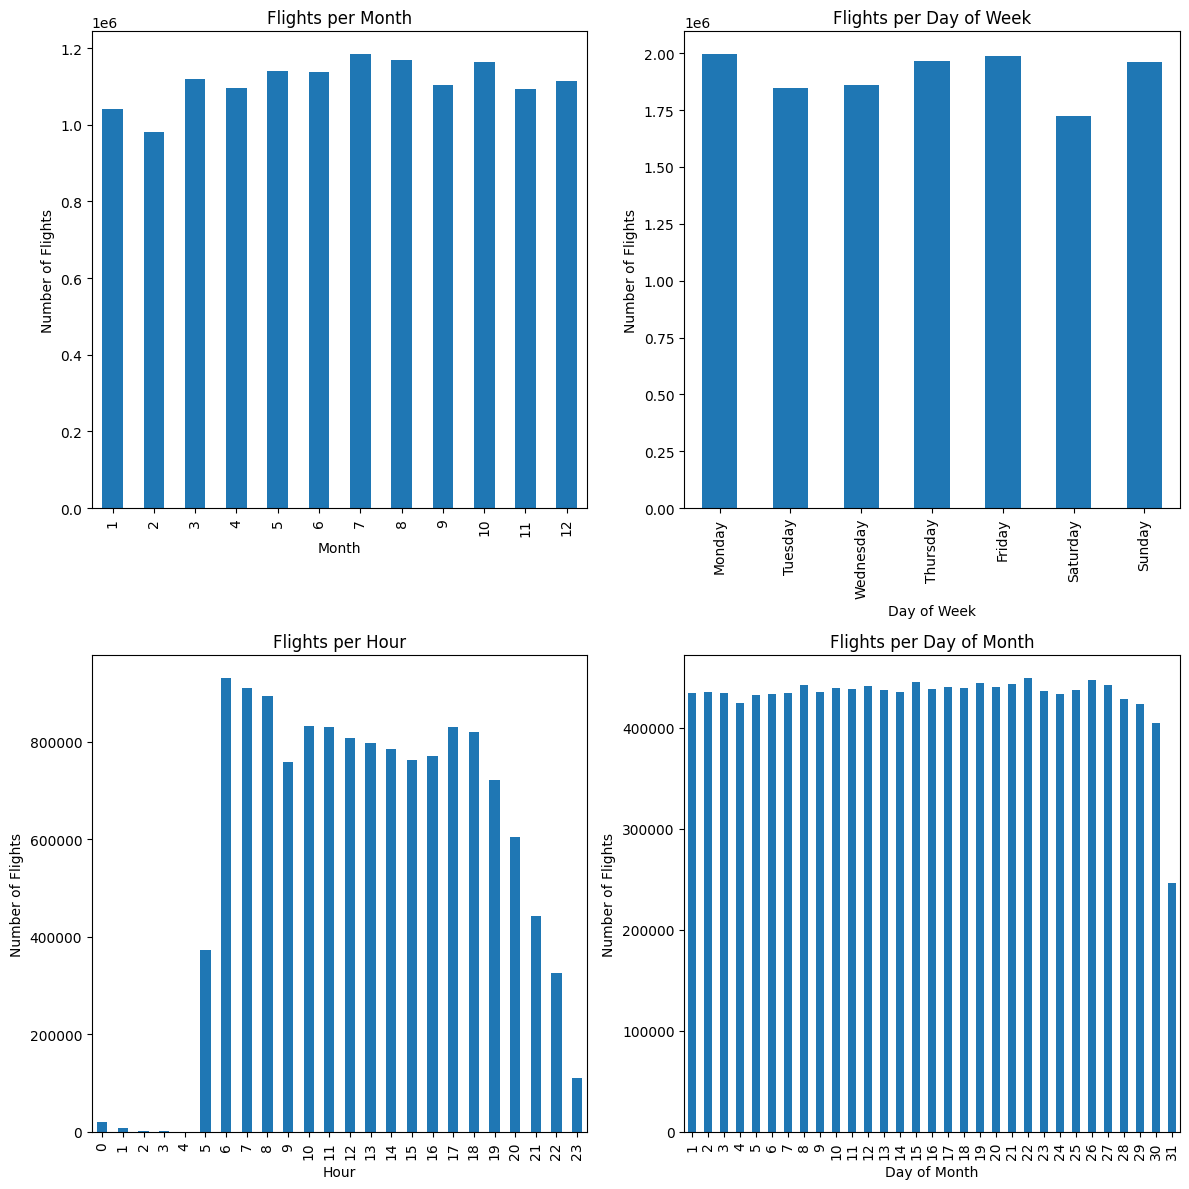

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# Flights per Month
plt.subplot(2, 2, 1)
data.groupby('MONTH').size().plot(kind='bar')
plt.title('Flights per Month')
plt.xlabel('Month')
plt.ylabel('Number of Flights')

# Flights per Day of Week
plt.subplot(2, 2, 2)
data.groupby('DAY_OF_WEEK').size().plot(kind='bar')
plt.title('Flights per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Flights per Hour
data['HOUR'] = data['dep_datetime'].dt.hour
plt.subplot(2, 2, 3)
data.groupby('HOUR').size().plot(kind='bar')
plt.title('Flights per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Flights')

# Flights per Day of Month
plt.subplot(2, 2, 4)
data.groupby('DAY_OF_MONTH').size().plot(kind='bar')
plt.title('Flights per Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Number of Flights')

# Adjust layout to avoid overlap
plt.tight_layout()

**Flights Per Month**: The distribution of the number of flights per month appears to be well rounded and fairly evenly distributed through the year with July having the most flights and February having the least. 

**Flights Per D.o.W**: The distribution of the number of flights per day of the week appear to be well rounded and fairly even throughout each day, with Monday having the highest number of flights and Saturday having the least.

**Flights Per Hour**: The distribution of number of flights per hour shows that the majority of flights occur during the day (6 am - 6 pm) while the remaining hours have large drops in the number of flights. This makes sense because most people tend to fly during the day rather than late at night.

**Flights Per D.o.M**: The distribution of number of flight per day of the month shows a relatively even distribution in the number of flights per day. However, the 31st day has about half of the number of flights compared to the other days (this could be explained by the fact that only 7 of the 12 months have 31 days while 11 of the 12 have at least 30)

<Axes: title={'center': 'Average Arrival Delay by Month'}, xlabel='MONTH'>

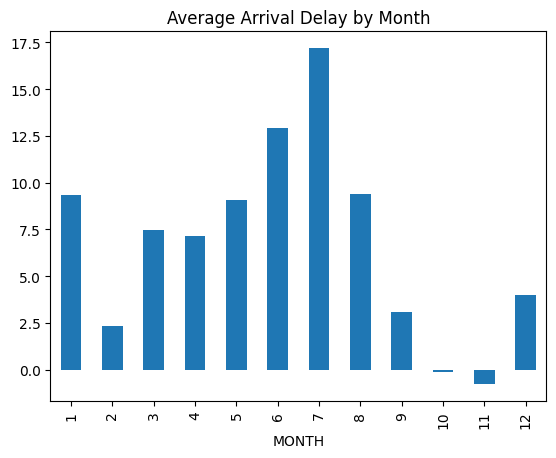

In [26]:
data.groupby('MONTH')['ARR_DELAY'].mean().plot(kind='bar', title='Average Arrival Delay by Month')


**Average Delay Per Month**: This distribution shows that the majority of delays occur during summer months (July, June, August) and winter months (January). This is likely caused by weather such as thunderstorms or hurricanes in the summer and snow storms in the winter.

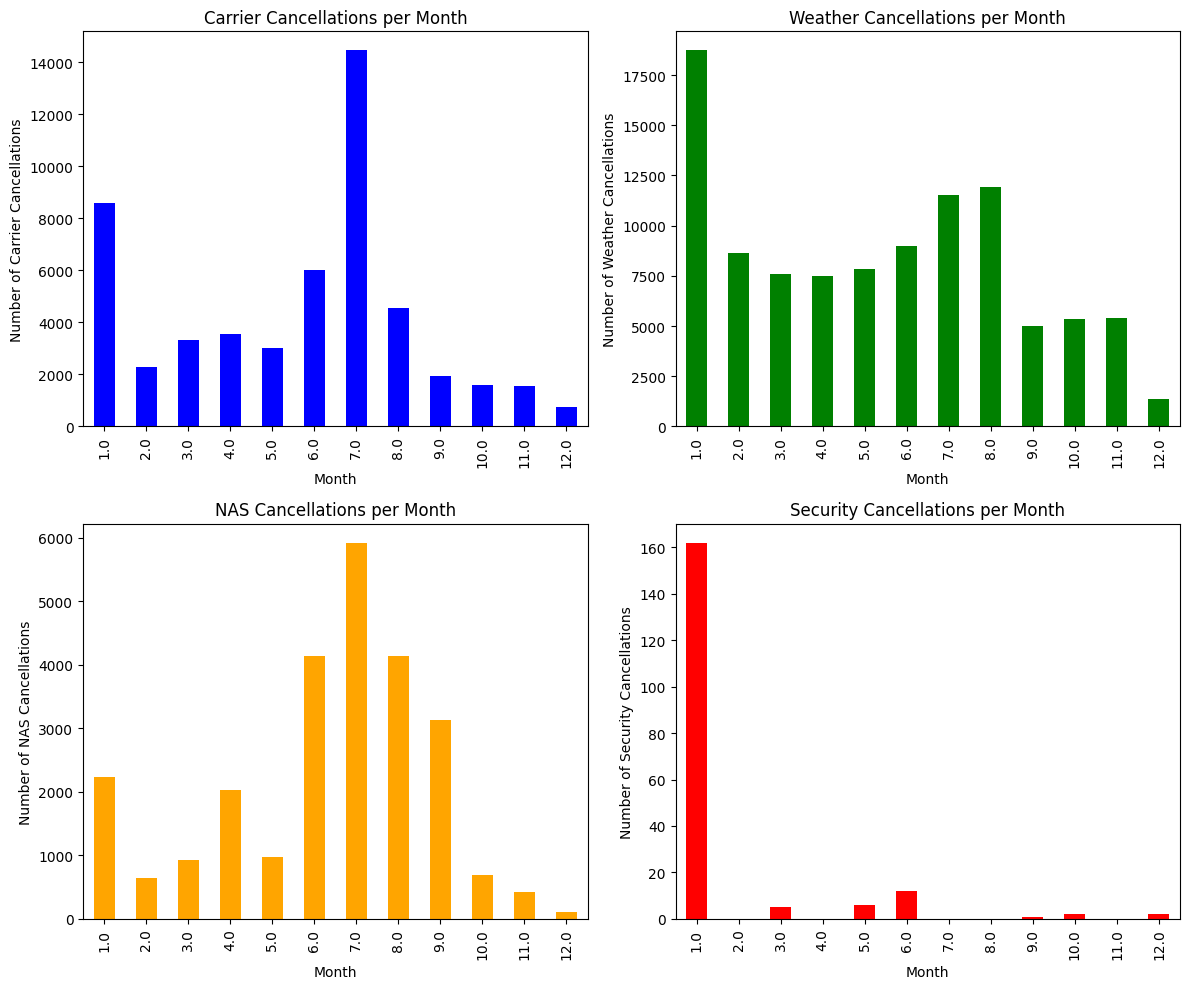

In [21]:
# Extract month from the 'date' column if not already done
data['month'] = data['date'].dt.month

# Group by month and sum up the different types of cancellations
carrier_canceled = data.groupby('month')['CarrierCancellation'].sum()
weather_canceled = data.groupby('month')['WeatherCancellation'].sum()
nas_canceled = data.groupby('month')['NASCancellation'].sum()
security_canceled = data.groupby('month')['SecurityCancellation'].sum()

# Create subplots
plt.figure(figsize=(12, 10))

# Carrier Cancellations
plt.subplot(2, 2, 1)
carrier_canceled.plot(kind='bar', color='blue')
plt.title('Carrier Cancellations per Month')
plt.xlabel('Month')
plt.ylabel('Number of Carrier Cancellations')

# Weather Cancellations
plt.subplot(2, 2, 2)
weather_canceled.plot(kind='bar', color='green')
plt.title('Weather Cancellations per Month')
plt.xlabel('Month')
plt.ylabel('Number of Weather Cancellations')

# NAS Cancellations
plt.subplot(2, 2, 3)
nas_canceled.plot(kind='bar', color='orange')
plt.title('NAS Cancellations per Month')
plt.xlabel('Month')
plt.ylabel('Number of NAS Cancellations')

# Security Cancellations
plt.subplot(2, 2, 4)
security_canceled.plot(kind='bar', color='red')
plt.title('Security Cancellations per Month')
plt.xlabel('Month')
plt.ylabel('Number of Security Cancellations')

plt.tight_layout()
plt.show()


**Carrier Cancellations Per Month**: The distribution shows that the majority of the carrier related cancellations occur during July and January, followed then by August and June. 

**Weather Cancellations Per Month**: The distribution shows that the majority of the weather related cancellations occur during January, August, and July.

**NAS Cancellations Per Month**: The distribution shows that the majority of the NAS related cancellations occur during June - September, with a peak in July.

**Security Cancellations Per Month**: The distribution shows that nearly all Security related cancellations occur in January. 

**Seasonality**: Many cancellations are heavily influenced by seasonal factors like holidays, weather patterns (snowstorms in winter, thunderstorms in summer), and the overall increase in travel during peak seasons (summer and the end of the year).

**Operational Stress during High Traffic Periods**: With more passengers flying in high season months (especially summer and winter), airlines and airports face more strain, which can lead to operational inefficiencies, including cancellations.

**Unpredictable Events**: For all cancellation types, there may be specific years or months that face unpredictable, external events (like natural disasters or security threats), which can skew the data for that particular month.

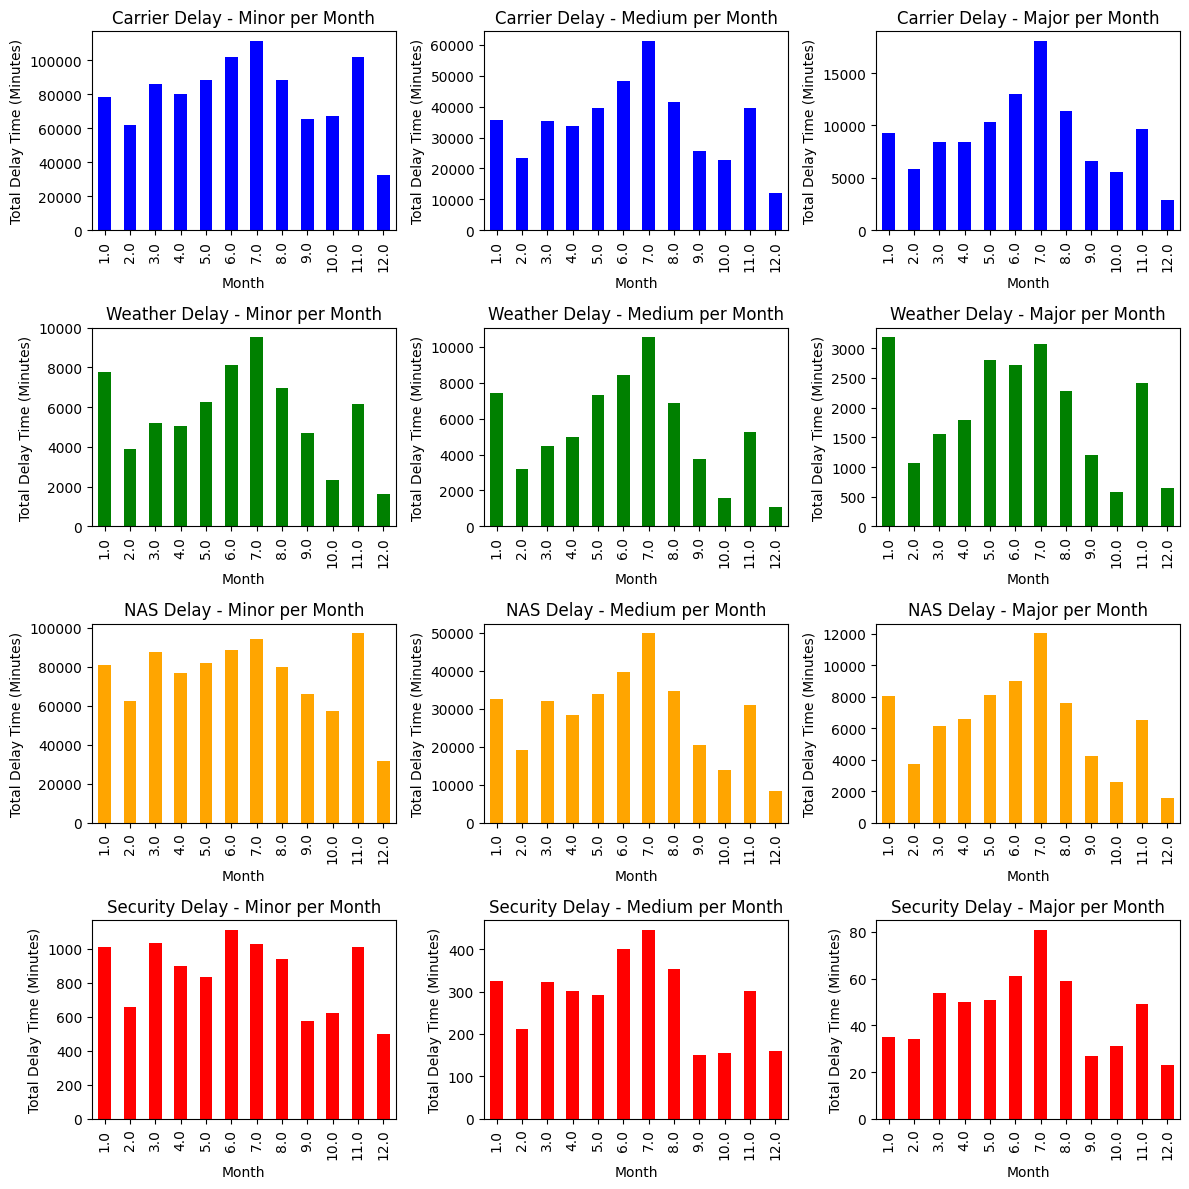

In [22]:
# Extract month from the 'date' column if not already done
data['month'] = data['date'].dt.month

# Define the delay types and their tiers
delay_types = ['Carrier', 'Weather', 'NAS', 'Security']
tiers = ['Minor', 'Medium', 'Major']

# Create a figure for subplots
plt.figure(figsize=(12, 12))

# Loop through each delay type and tier to create subplots
for i, delay_type in enumerate(delay_types):
    for j, tier in enumerate(tiers):
        # Construct the column name for the current delay type and tier
        delay_column = f'{delay_type}{tier}'
        
        # Group the data by month and sum up the delay times for this delay type and tier
        delay_per_month = data.groupby('month')[delay_column].sum()
        
        # Create a subplot for each delay type and tier
        plt.subplot(len(delay_types), len(tiers), i * len(tiers) + j + 1)
        delay_per_month.plot(kind='bar', color='blue' if delay_type == 'Carrier' else 'green' if delay_type == 'Weather' else 'orange' if delay_type == 'NAS' else 'red')
        
        # Set plot title and labels
        plt.title(f'{delay_type} Delay - {tier} per Month')
        plt.xlabel('Month')
        plt.ylabel('Total Delay Time (Minutes)')

plt.tight_layout()
plt.show()


**Carrier Delays**: 
* Minor: Most minor delays occur in July, June, and Novemeber.
* Medium: Most medium delays occur in July, June, August, and Novemeber.
* Major: Most medium delays occur in July, June, August, and Novemeber.

**Weather Delays**:
* Minor: Most minor delays occur in July, June, January, and August.
* Medium: Most medium delays occur in July, June, January, and May.
* Major: Most major delays occur in Januray, July, May, and June.

**NAS Delays**:
* Minor: Most minor delays occur in Novemeber, July, March, and June.
* Medium: Most medium delays occur in July, June, August, and May.
* Major: Most major delays occur in July, June, January, and May.

**Security Delays**:
* Minor: Most minor delays occur in June, July, March, November, and January.
* Medium: Most medium delays occur in July, June, August, and January.
* Major: Most major delays occur in July, June, August, and March. 

**Seasonality and Increased Travel**: The patterns often correlate with peak travel periods. Summer (June-July-August) and the winter holidays (November-January) drive up travel volume, which increases the likelihood of delays, especially in areas like carrier, NAS, and security operations.

**Weather-Related Impacts**: Weather conditions significantly affect delays, especially in winter (snow, ice) and summer (thunderstorms). The months with the highest weather-related disruptions tend to show a high number of delays across all tiers.

**Operational Strain**: Periods of high passenger traffic put more strain on airport operations, increasing the likelihood of delays across all categories, from minor to major. This includes delays due to air traffic control, carrier operations, and security measures.

**External Factors**: External events such as holidays, spring breaks, and specific operational bottlenecks can drive up the frequency and severity of delays, especially in high-traffic months like July, June, and November.

## Flight Duration and Distance

<Axes: xlabel='DISTANCE', ylabel='AIR_TIME'>

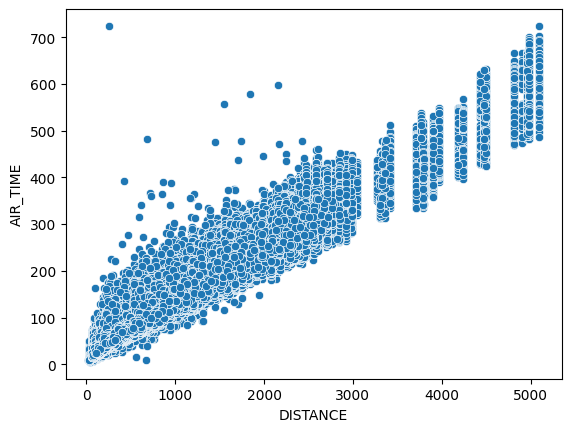

In [23]:
sns.scatterplot(x='DISTANCE', y='AIR_TIME', data=data)

**Distance**: The distribution appears to have a positive slope (which is to be expected since the longer the distance, the higher air time will be). However, there are a few outliers towards the beginning of the graph where there are flights with short distances but very high air times. This could be caused by weather delays or the plane being unable to land for any given reason. Additionally, there is some clustering towards the tail end of the graph (unsure of the cause of this).

<Axes: xlabel='DISTANCE', ylabel='ARR_DELAY'>

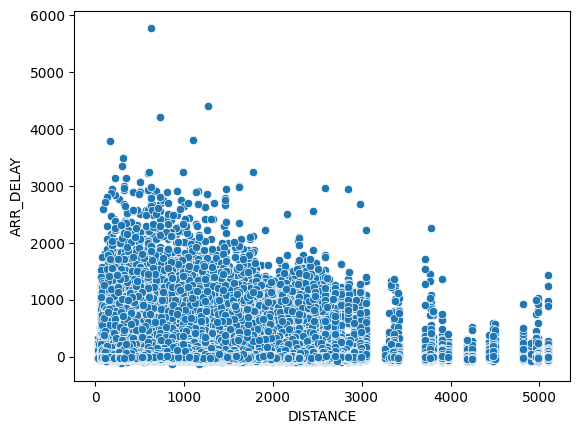

In [29]:
sns.scatterplot(x='DISTANCE', y='ARR_DELAY', data=data)

**Distance on Delays**: The scatterplot shows us the distribution and the effect that distance has on delay times. There are a few things to point out with this however, specifically the clustering towards the tail of the plot and the massive outliers (flights with insane delay times are unrealistic and could be mislabeled cancellations).

## Carrier Performance

<Axes: title={'center': 'Average Delay by Carrier'}, ylabel='OP_UNIQUE_CARRIER'>

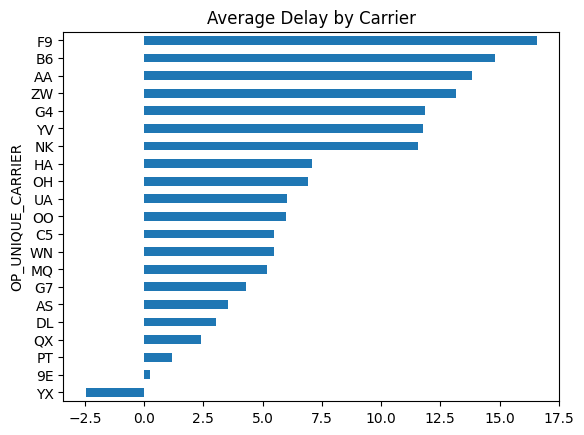

In [31]:
data.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].mean().sort_values().plot(kind='barh', title='Average Delay by Carrier')

**Delay by Carrier**: This graph shows the distribution of which carrier's (airlines) have the most delays. In this case, F9, B6, AA, and ZW have the highest average delays while carriers such as YX average early arrivals rather than delays.

## Weather Analysis

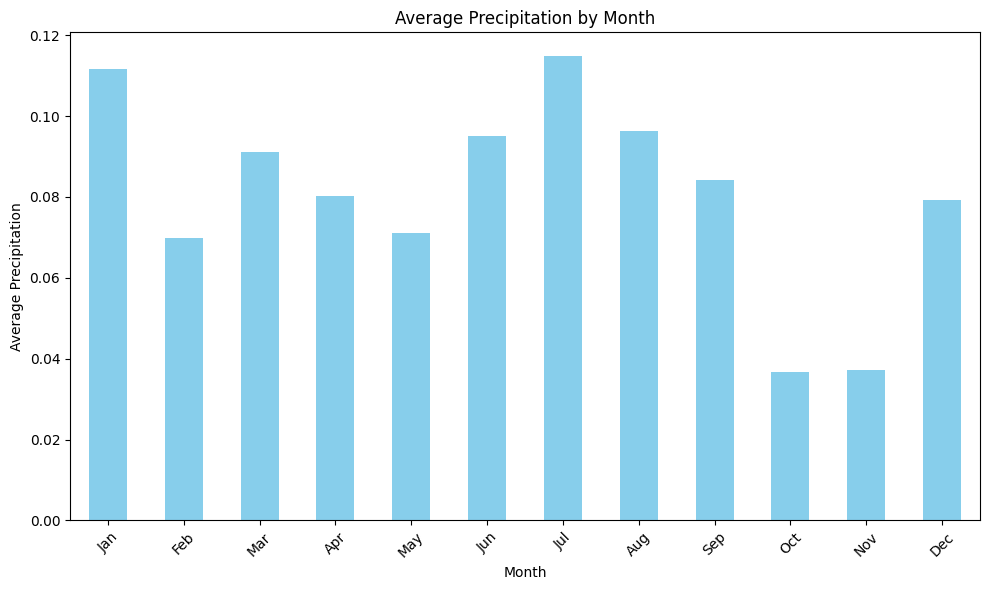

In [39]:
# Ensure 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Extract the month from the 'date' column
data['month'] = data['date'].dt.month

# Group by month and calculate the mean precipitation for each month
precip_by_month = data.groupby('month')['precipitation'].mean()

# Plot Precipitation by Month (Bar plot)
plt.figure(figsize=(10, 6))
precip_by_month.plot(kind='bar', color='skyblue')
plt.title('Average Precipitation by Month')
plt.xlabel('Month')
plt.ylabel('Average Precipitation')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.show()


**Precipitation Per Month**: Based on this distribution of precipitation per month, we can see similarities with previous graphs, suggesting that summer and winter months have high amounts of precipitation and therefore cause a majority of the delays or cancellations.

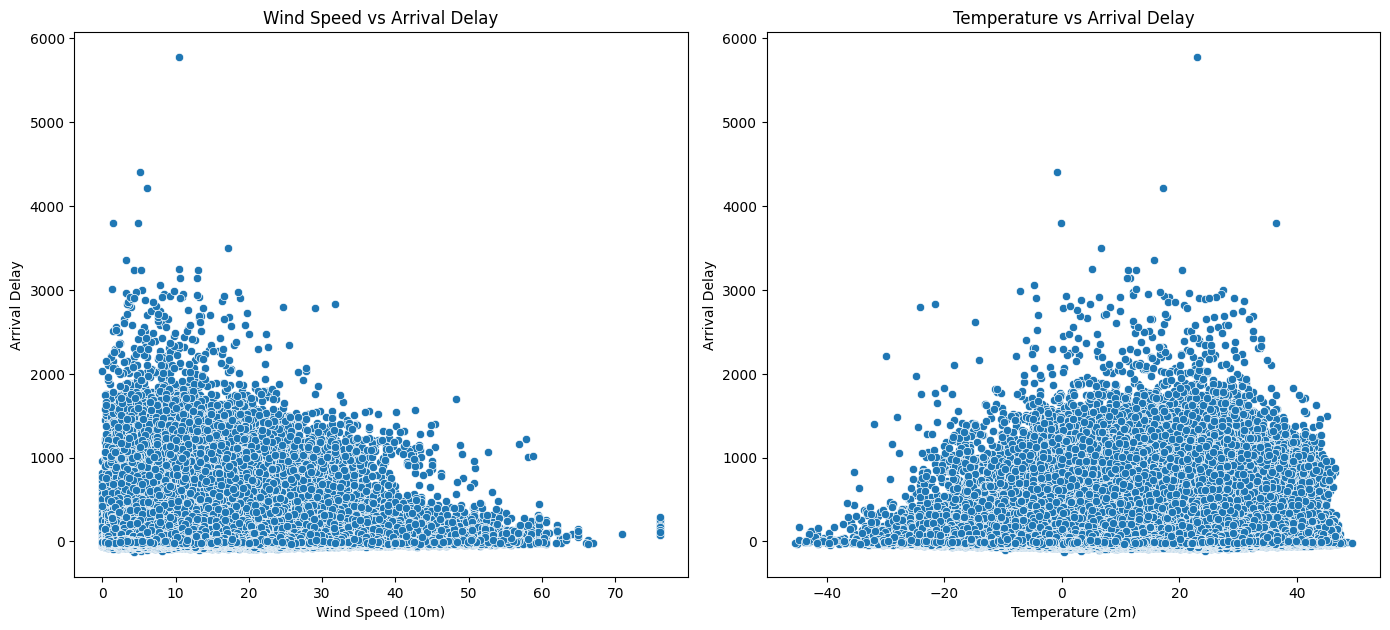

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'date' column is in datetime format, and create a 'month' column
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['month'] = data['date'].dt.month

# Create subplots with 2 rows and 2 columns
plt.figure(figsize=(14, 12))

# Wind Speed vs. Arrival Delay (Scatterplot)
plt.subplot(2, 2, 3)
sns.scatterplot(x='wind_speed_10m', y='ARR_DELAY', data=data)
plt.title('Wind Speed vs Arrival Delay')
plt.xlabel('Wind Speed (10m)')
plt.ylabel('Arrival Delay')

# Temperature vs. Arrival Delay (Scatterplot)
plt.subplot(2, 2, 4)
sns.scatterplot(x='temperature_2m', y='ARR_DELAY', data=data)
plt.title('Temperature vs Arrival Delay')
plt.xlabel('Temperature (2m)')
plt.ylabel('Arrival Delay')

# Tight layout for better spacing
plt.tight_layout()
plt.show()


**Wind Speed vs Delay**: The distribution of wind speed against delay times shows that in general, as the wind speed is higher, there are fewer delays.

**Temperature vs Delay**: The distribution of temperature against delay times show that temperatures are not particularly important for delay times. However, temperature could indirectly impact weather/precipitation which is very significant in affecting delays and cancellations.

## Drop Unneeded Data

In [40]:
# Must then drop a LOT of data (cannot use current flight times to predict future flight times)

# Drop columns that are unavailable when making predictions 7 days ahead
columns_to_drop = [
    'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY',
    'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ACTUAL_ELAPSED_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY',
    'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME',
    'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DUPLICATE',
    
    # Diverted flight-related columns
    "DIVERTED", "DIV_AIRPORT_LANDINGS", "DIV_REACHED_DEST", 
    "DIV_ACTUAL_ELAPSED_TIME", "DIV_ARR_DELAY", "DIV_DISTANCE"
] 

# Add dynamically generated diversion-related columns
columns_to_drop += [
    f"DIV{i}_{suffix}" for i in range(1, 6) for suffix in [
        "AIRPORT", "AIRPORT_ID", "AIRPORT_SEQ_ID", "WHEELS_ON", "TOTAL_GTIME", 
        "LONGEST_GTIME", "WHEELS_OFF", "TAIL_NUM"
    ]
]

# Columns with excessive missing data (>99%)
columns_to_drop += [
    "SCH_OP_UNIQUE_CARRIER", "SCH_OP_CARRIER_AIRLINE_ID", "SCH_OP_CARRIER", 
    "SCH_OP_CARRIER_FL_NUM"
]

# Redundant/unnecessary columns
columns_to_drop += [
    "YEAR", "QUARTER", "DAY_OF_MONTH", "MKT_UNIQUE_CARRIER", "BRANDED_CODE_SHARE",
    "MKT_CARRIER_AIRLINE_ID", "MKT_CARRIER", "MKT_CARRIER_FL_NUM", "TAIL_NUM",
    "DUP", "DISTANCE_GROUP", "ORIGIN_CITY_NAME", "ORIGIN_STATE_ABR", "ORIGIN_STATE_NM",
    "DEST_CITY_NAME", "DEST_STATE_ABR", "DEST_STATE_NM", "ORIGIN_STATE_FIPS",
    "DEST_STATE_FIPS", "ORIGIN_WAC", "DEST_WAC"
]

# Potentially unusable weather features
columns_to_drop += [
    "wind_speed_80m", "wind_speed_120m", "soil_temperature_0cm", 
    "soil_moisture_0_to_1cm", "et0_fao_evapotranspiration", "evapotranspiration"
]

# Drop columns from dataset
data = data.drop(columns=columns_to_drop, errors='ignore')

In [41]:
data.shape

(13343154, 79)

**Data Shape Post Data Drop**: Number of features drops from 179 to 79 after dropping unuseful/unusable data

# Prepare the Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [ ]:
# Define target variable (e.g., Predicting departure delay)
target = ""  # Unsure of what to put here. Does he want all 20 of the different delay types?

# Feature Selection: Exclude columns with high missing values and non-useful ones
drop_cols = [
    "FL_DATE", "TAIL_NUM", "CANCELLATION_CODE", "DUP",
    "SCH_OP_UNIQUE_CARRIER", "SCH_OP_CARRIER_AIRLINE_ID", "SCH_OP_CARRIER",
    "FIRST_DEP_TIME", "TOTAL_ADD_GTIME", "LONGEST_ADD_GTIME",
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"
]

data = data.drop(columns=drop_cols)

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify numerical and categorical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# Define preprocessing steps
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing values with median
    ("scaler", StandardScaler())  # Standardize numerical features
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical variables
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# Create pipeline with Random Forest
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

KeyError: "['FL_DATE', 'TAIL_NUM', 'CANCELLATION_CODE', 'DUP', 'SCH_OP_UNIQUE_CARRIER', 'SCH_OP_CARRIER_AIRLINE_ID', 'SCH_OP_CARRIER', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'] not found in axis"

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
pipeline.fit(X_train, y_train)

# Evaluate
print("Training Accuracy:", pipeline.score(X_train, y_train))
print("Test Accuracy:", pipeline.score(X_test, y_test))